PDE Constrained Optimisation with G-ADOPT - Boundary Values
===========================================================

In this tutorial, we undertake an inversion for an (unknown) initial condition, to match given
time-dependent boundary values. This differs to our previous tutorial, where our goal was to
match a given final state.

We start with our usual imports:

In [1]:
from gadopt import *
from gadopt.inverse import *

Create synthetic twin experiment and record solution at all timesteps
---------------------------------------------------------------------

Note that the setup is similar to our previous example, except that the velocity is now counter
clockwise around the origin $(0,0)$ in the corner of the unit square domain. This implies an inflow
at the bottom boundary and an outflow boundary on the left of the domain.

In [2]:
mesh = UnitSquareMesh(40, 40)
mesh.cartesian = True
boundary = get_boundary_ids(mesh)

V = VectorFunctionSpace(mesh, "CG", 2)
Q = FunctionSpace(mesh, "CG", 1)
T = Function(Q, name='Temperature')
T0 = Function(Q, name="Initial_Temperature")  # T Initial condition which we will invert for.
T0_ref = Function(Q, name="Reference_Initial_Temperature")

x, y = SpatialCoordinate(mesh)
u = Function(V, name="Velocity").interpolate(as_vector((-y, x)))

approximation = BoussinesqApproximation(Ra=1, kappa=5e-2)

delta_t = 0.1
energy_solver = EnergySolver(T, u, approximation, delta_t, ImplicitMidpoint)

The initial condition that we, again, later will invert for, is now centered in the domain.

In [3]:
x0, y0 = 0.5, 0.5
w = .2
r2 = (x-x0)**2 + (y-y0)**2
T0_ref.interpolate(exp(-r2/w**2))

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x72ced816bcb0>, FiniteElement('Lagrange', triangle, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0)), 6)

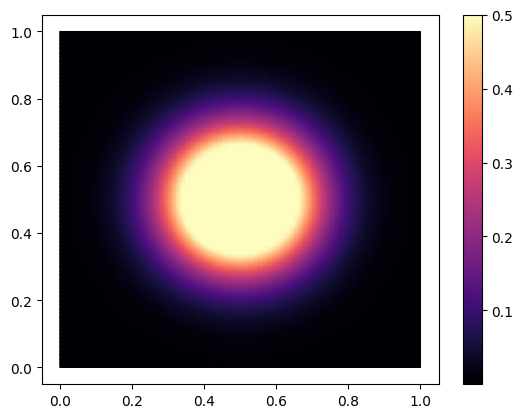

In [4]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
collection = tripcolor(T0_ref, axes=axes, cmap='magma', vmax=0.5)
fig.colorbar(collection);

After setting the initial condition for T, we run this simulation for 20 timesteps to ensure
the entire Gaussian has left the domain. For this example, we checkpoint the solution at every
timestep, so that we can later use it as the target boundary values.

In [5]:
num_timesteps = 20
T.project(T0_ref)
with CheckpointFile("Model_State.h5", "w") as model_checkpoint:
    model_checkpoint.save_mesh(mesh)
    for timestep in range(num_timesteps):
        model_checkpoint.save_function(T, idx=timestep)
        energy_solver.solve()
    # After saving idx=0, 19 at beginning of each timestep, we include idx=20 for the solution at
    # the end of the final timestep:
    model_checkpoint.save_function(T, idx=timestep)

The solution has almost completely disappeared (note the different scalebar):

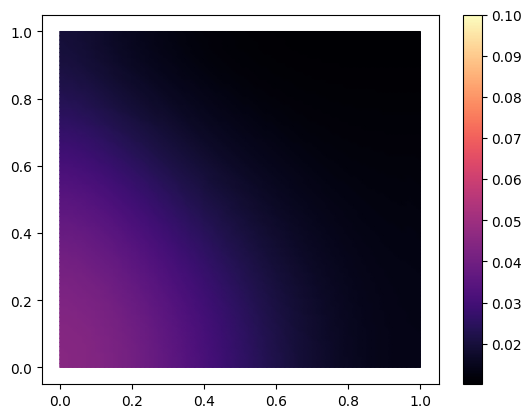

In [6]:
fig, axes = plt.subplots()
collection = tripcolor(T, axes=axes, cmap='magma', vmax=0.1)
fig.colorbar(collection);

Advection diffusion model with unknown initial condition
--------------------------------------------------------

As with our previous example, we again set up the model with the same configuration, albeit where we
do not know the initial condition. We will try to find the optimal initial condition such that we closely
match the recorded outflow boundary values.

In [7]:
with CheckpointFile("Model_State.h5", "r") as model_checkpoint:
    mesh = model_checkpoint.load_mesh()
    mesh.cartesian = True

We now set up the model exactly as before:

In [8]:
V = VectorFunctionSpace(mesh, "CG", 2)
Q = FunctionSpace(mesh, "CG", 1)
T = Function(Q, name='Temperature')
T0 = Function(Q, name="Initial_Temperature")
T0_ref = Function(Q, name="Reference_Initial_Temperature")
T_wrong = Function(Q, name="Wrong_Initial_Temperature")

x, y = SpatialCoordinate(mesh)
u = Function(V, name="Velocity").interpolate(as_vector((-y, x)))

approximation = BoussinesqApproximation(Ra=1, kappa=5e-2)
delta_t = 0.1
energy_solver = EnergySolver(T, u, approximation, delta_t, ImplicitMidpoint)

# Make our solver output a little less verbose:
if "ksp_converged_reason" in energy_solver.solver_parameters:
    del energy_solver.solver_parameters["ksp_converged_reason"]

As a first guess we use a Gaussian that is in the wrong place: centred around $(0.7, 0.7)$
instead of $(0.5, 0.5)$:

In [9]:
x0, y0 = 0.7, 0.7
w = .2
r2 = (x-x0)**2 + (y-y0)**2
T_wrong.interpolate(exp(-r2/w**2))

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x72ce7f83bd10>, FiniteElement('Lagrange', triangle, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 92)), 200)

As in our first example, we make sure to clear the tape before our actual model starts and
specify the control at the right stage. During the model we load back in the solutions from the synthetic twin,
but only use its values at the boundary to compute a mismatch with the current model as an integral over the left
boundary. Note that we start calculating the functional already in the first timestep, and we keep on adding terms to it,
all of which will still be automatically recorded by the pyadjoint tape.

In [10]:
tape = get_working_tape()
tape.clear_tape()

T0.project(T_wrong)

m = Control(T0)

J = AdjFloat(0.0)  # Initialise functional
factor = AdjFloat(0.5)  # First & final boundary integral weighted by 0.5 to implement mid-point rule time-integration.

T.project(T0)
with CheckpointFile("Model_State.h5", "r") as model_checkpoint:
    for timestep in range(num_timesteps):
        T_target = model_checkpoint.load_function(mesh, 'Temperature', idx=timestep)
        J = J + factor * assemble((T-T_target)**2*ds(boundary.left))
        factor = 1.0  # Remaining timesteps weighted by 1
        energy_solver.solve()

    T_target = model_checkpoint.load_function(mesh, 'Temperature', idx=timestep)
    # Add final contribution weighted again by 0.5
    J = J + factor * assemble((T-T_target)**2*ds(boundary.left))

print(J)

0.07749995459676606


We define the reduced functional using the final value of `J` and the specified control. This allows us to rerun
the model with an arbitrary initial condition. As with our previous example, we first try to simply rerun the
model with the same "wrong" initial condition, and print the functional.

In [11]:
reduced_functional = ReducedFunctional(J, m)
print(reduced_functional(T_wrong))

0.07749995459676606


Now we re run the model with the "correct" initial condition from the twin experiment, ending up with
a near-zero misfit.

In [12]:
x0, y0 = 0.5, 0.5
w = .2
r2 = (x-x0)**2 + (y-y0)**2
T0_ref.interpolate(exp(-r2/w**2))

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x72ce7f83bd10>, FiniteElement('Lagrange', triangle, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 92)), 198)

In [13]:
print(reduced_functional(T0_ref))

6.6454211188233276e-06


We can again look at the gradient. We evaluate the gradient
around an initial guess of T=0 as the initial condition, noting
that when a Function is created its associated data values are zero.

In [14]:
T_wrong.assign(0.0)
reduced_functional(T_wrong)

0.2512941576647654

In unstructured mesh optimisation problems, it is important to work in the L2 Riesz representation
to ensure a grid-independent result:

In [15]:
gradJ = reduced_functional.derivative(options={"riesz_representation": "L2"})

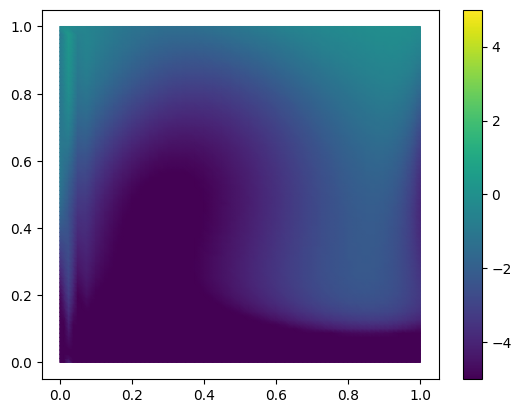

In [16]:
fig, axes = plt.subplots()
collection = tripcolor(gradJ, axes=axes, cmap='viridis', vmin=-5, vmax=5)
fig.colorbar(collection);

Invert for optimal initial condition using gradient-based optimisation algorithm
--------------------------------------------------------------------------------

As in the previous example, we can now use ROL to invert for the inital condition.
We last evaluated the reduced functional with a zero initial condition as the control value,
so this will be our initial guess.

We first set lower and upper bound values for the control, which we can
provide as functions in the same function space as the control:

In [17]:
T_lb = Function(Q).assign(0.0)
T_ub = Function(Q).assign(1.0)

We next specify our minimisation problem using the LinMore algorithm. As this case is a
little more challenging than our previous tutorial, we specify 50 iterations as the limit.

In [18]:
minimisation_problem = MinimizationProblem(reduced_functional, bounds=(T_lb, T_ub))
minimisation_parameters["Status Test"]["Iteration Limit"] = 50

# Define the LinMore Optimiser class:
optimiser = LinMoreOptimiser(
    minimisation_problem,
    minimisation_parameters,
)

And again use our callback function to record convergence:

In [19]:
functional_values = []


def record_value(value, *args):
    if functional_values:
        functional_values.append(min(value, min(functional_values)))
    else:
        functional_values.append(value)


reduced_functional.eval_cb_post = record_value

We next run the optimisation:

In [20]:
optimiser.run()


Lin-More Trust-Region Method (Type B, Bound Constraints)
  iter  value          gnorm          snorm          delta          #fval     #grad     #hess     #proj     tr_flag   iterCG    flagCG    
  0     2.512942e-01   9.730735e-01   ---            1.000000e+00   1         1         0         2         ---       ---       ---       


  1     2.512942e-01   9.730735e-01   9.970268e-01   2.492567e-01   2         1         4         7         2         0         0         


  2     2.512942e-01   9.730735e-01   2.492567e-01   6.231418e-02   3         1         21        19        2         8         3         


  3     1.398485e-01   7.049145e-01   6.231418e-02   6.231418e-02   4         2         26        24        0         2         3         


  4     1.398485e-01   7.049145e-01   2.131429e-02   5.328573e-03   5         2         41        30        2         10        1         


  5     1.322613e-01   7.120842e-01   5.328573e-03   5.328573e-03   6         3         62        43        0         10        1         


  6     1.252120e-01   7.397731e-01   5.245016e-03   5.328573e-02   7         4         77        51        0         10        1         


  7     1.103025e-01   7.817187e-01   1.080576e-02   5.328573e-01   8         5         91        57        0         10        1         


  8     7.722533e-02   8.109672e-01   2.793263e-02   5.328573e+00   9         6         105       63        0         10        1         


  9     5.846680e-02   4.082384e-01   6.416686e-02   5.328573e+01   10        7         118       68        0         10        1         


  10    3.346408e-02   3.108484e-01   1.055538e-02   5.328573e+02   11        8         131       72        0         10        1         


  11    3.219637e-02   3.217317e-01   1.948306e-03   5.328573e+03   12        9         144       77        0         10        1         


  12    3.092001e-02   3.375663e-01   1.819457e-03   5.328573e+04   13        10        157       82        0         10        1         


  13    2.770807e-02   3.500349e-01   5.920215e-03   5.328573e+05   14        11        170       87        0         10        1         


  14    2.262432e-02   3.478144e-01   1.097739e-02   5.328573e+06   15        12        183       92        0         10        1         


  15    2.016705e-02   3.871509e-01   1.896204e-02   5.328573e+07   16        13        196       97        0         10        1         


  16    1.522114e-02   2.604325e-01   7.444520e-03   5.328573e+08   17        14        209       102       0         10        1         


  17    1.430663e-02   2.299542e-01   3.830272e-03   5.328573e+09   18        15        222       107       0         10        1         


  18    1.341042e-02   2.205176e-01   2.955549e-03   5.328573e+10   19        16        236       113       0         10        1         


  19    1.184265e-02   2.202902e-01   5.342161e-03   5.328573e+11   20        17        250       119       0         10        1         


  20    1.015155e-02   2.030560e-01   6.910755e-03   5.328573e+12   21        18        264       125       0         10        1         


  21    9.472086e-03   1.772844e-01   2.795669e-03   5.328573e+13   22        19        277       130       0         10        1         


  22    8.426315e-03   1.420380e-01   6.207780e-03   5.328573e+14   23        20        290       135       0         10        1         


  23    7.656868e-03   1.374520e-01   5.279115e-03   5.328573e+15   24        21        303       140       0         10        1         


  24    7.193732e-03   1.226151e-01   2.563479e-03   5.328573e+16   25        22        316       145       0         10        1         


  25    6.712520e-03   1.322570e-01   3.433767e-03   5.328573e+17   26        23        329       150       0         10        1         


  26    6.044341e-03   1.383960e-01   5.568236e-03   5.328573e+18   27        24        342       155       0         10        1         


  27    5.460526e-03   1.383758e-01   5.130370e-03   5.328573e+19   28        25        355       160       0         10        1         


  28    5.004609e-03   1.193260e-01   3.516833e-03   1.000000e+20   29        26        368       165       0         10        1         


  29    4.632203e-03   1.225904e-01   3.731861e-03   1.000000e+20   30        27        381       170       0         10        1         


  30    4.413085e-03   1.204403e-01   2.436292e-03   1.000000e+20   31        28        394       175       0         10        1         


  31    3.995210e-03   1.193136e-01   5.093606e-03   1.000000e+20   32        29        408       181       0         10        1         


  32    3.706623e-03   1.362332e-01   4.176391e-03   1.000000e+20   33        30        422       187       0         10        1         


  33    3.525259e-03   1.223801e-01   2.470655e-03   1.000000e+20   34        31        435       192       0         10        1         


  34    3.359789e-03   1.092495e-01   2.513746e-03   1.000000e+20   35        32        449       198       0         10        1         


  35    3.199949e-03   1.106883e-01   2.743189e-03   1.000000e+20   36        33        464       205       0         10        1         


  36    2.991478e-03   1.142616e-01   4.085484e-03   1.000000e+20   37        34        478       211       0         10        1         


  37    2.803724e-03   9.801914e-02   4.346091e-03   1.000000e+20   38        35        492       217       0         10        1         


  38    2.681036e-03   1.149673e-01   4.966714e-03   1.000000e+20   39        36        505       222       0         10        1         


  39    2.626709e-03   8.929282e-02   1.126009e-03   1.000000e+20   40        37        518       227       0         10        1         


  40    2.592514e-03   9.851259e-02   1.451628e-03   1.000000e+20   41        38        531       232       0         10        1         


  41    2.541489e-03   1.063217e-01   2.286997e-03   1.000000e+20   42        39        544       237       0         10        1         


  42    2.444348e-03   1.215463e-01   3.934586e-03   1.000000e+20   43        40        557       242       0         10        1         


  43    2.316489e-03   1.251990e-01   4.265675e-03   1.000000e+20   44        41        570       247       0         10        1         


  44    2.228479e-03   1.096366e-01   1.540431e-03   1.000000e+20   45        42        583       252       0         10        1         


  45    2.090900e-03   1.008647e-01   2.930926e-03   1.000000e+20   46        43        597       258       0         10        1         


  46    2.021454e-03   1.062382e-01   1.414232e-03   1.000000e+20   47        44        612       265       0         10        1         


  47    1.861213e-03   1.015283e-01   2.645664e-03   1.000000e+20   48        45        627       272       0         10        1         


  48    1.625563e-03   9.056573e-02   3.855734e-03   1.000000e+20   49        46        642       279       0         10        1         


  49    1.361091e-03   8.320536e-02   4.557234e-03   1.000000e+20   50        47        655       284       0         10        1         


  50    1.167222e-03   9.158241e-02   5.249623e-03   1.000000e+20   51        48        668       289       0         10        1         
Optimization Terminated with Status: Last Type (Dummy)


And we'll write the functional values to a file so that we can test them.

In [21]:
with open("functional_boundary.txt", "w") as f:
    f.write("\n".join(str(x) for x in functional_values))

Let's see how well we have done. At this point a total number of 50 iterations
have been performed so let's plot convergence:

Text(0.5, 1.0, 'Convergence')

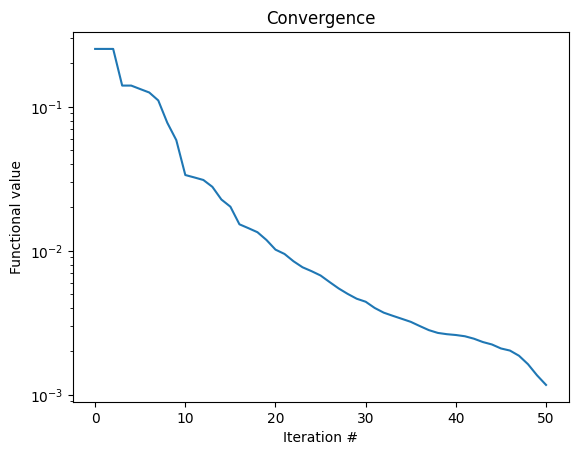

In [22]:
plt.semilogy(functional_values)
plt.xlabel("Iteration #")
plt.ylabel("Functional value")
plt.title("Convergence")

This demonstrates that the functional value decreases by roughly three orders of
magnitude over the 50 iterations considered. As with the previous tutorial, the
functional value can be reduced further if more iterations are specified, or if
the optimisation procedure is configured to continue until a specified tolerance
is achieved. We can also visualise the optimised initial condition and compare to
the true initial condition:

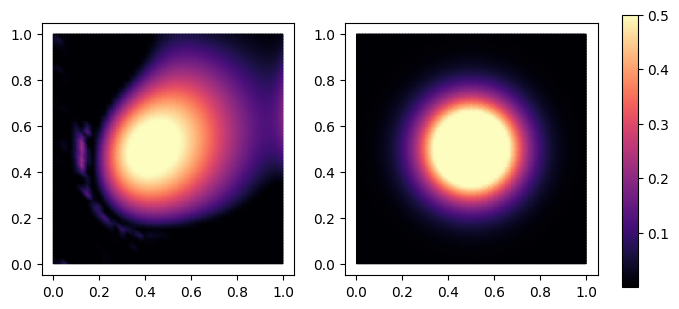

In [23]:
fig, axes = plt.subplots(1,2,figsize=[8,4],subplot_kw={'aspect':1.0})
ax1 = tripcolor(T0.block_variable.checkpoint, axes=axes[0], cmap='magma', vmax=0.5)
ax2 = tripcolor(T0_ref, axes=axes[1], cmap='magma', vmax=0.5)
fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.68])
fig.colorbar(ax2,cax=cbar_ax);

Not bad. Not bad at all! Thank you for listening! Crowd. Goes. Wild.